In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import hu_core_news_lg

In [2]:
# HuSpacy model loading
nlp = hu_core_news_lg.load()

In [3]:
# @InProceedings{HuSpaCy:2023,
#     author= {"Orosz, Gy{\"o}rgy and Szab{\'o}, Gerg{\H{o}} and Berkecz, P{\'e}ter and Sz{\'a}nt{\'o}, Zsolt and Farkas, Rich{\'a}rd"},
#     editor= {"Ek{\v{s}}tein, Kamil and P{\'a}rtl, Franti{\v{s}}ek and Konop{\'i}k, Miloslav"},
#     title = {{"Advancing Hungarian Text Processing with HuSpaCy: Efficient and Accurate NLP Pipelines"}},
#     booktitle = {{"Text, Speech, and Dialogue"}},
#     year = "2023",
#     publisher = {{"Springer Nature Switzerland"}},
#     address = {{"Cham"}},
#     pages = "58--69",
#     isbn = "978-3-031-40498-6"
# }

In [4]:
# Read tickets
df = pd.read_csv('tickets_generated_2.csv')

In [5]:
# Remove rows with missing Date or Description
df = df.dropna(subset=["Date", "Description"])
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [6]:
df

,Ticket_ID,Date,Machine,Description
0,1,2023-01-01,Hidraulikus prés-10,A vészjelző rendszer váratlan hibát jelzett.
1,2,2023-01-01,Hegesztő-MAX,A kenőrendszer olajszintje az alsó határérték ...
2,3,2023-01-01,Robot 2,A gépdiagnosztikai teszt során kommunikációs h...
3,4,2023-01-02,Optikai Mérő-2,Hirtelen áramfelvétel-növekedés figyelhető meg.
4,5,2023-01-02,Lézeres Vágó-Pro,A csapágyak extrém kopást mutatnak.
...,...,...,...,...
995,996,2023-11-28,Présgép-9,A berendezés érzékelője hamis riasztásokat gen...
996,997,2023-11-29,Szenzorvezérlő-3,A hőcserélő szivárog a csatlakozási pontnál.
997,998,2023-11-29,Hidraulikus prés-4,A szervomotor nem tartja a beállított pozíciót.
998,999,2023-11-29,Lézeres Vágó-A,Az elektromos motor szénkeféi elhasználódtak.


In [7]:
# Preprocess with HuSpacy
import re
from joblib import Parallel, delayed

In [8]:
def preprocess(text):
    text = re.sub(r'\d+', '', text)
    doc = nlp(text, disable=["parser", "ner"])
    tokens = (token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha)
    return " ".join(tokens)

In [9]:
df["Cleaned_Description"] = Parallel(n_jobs=-1, backend="threading")(delayed(preprocess)(text) for text in df["Description"])

In [10]:
df.head()

,Ticket_ID,Date,Machine,Description,Cleaned_Description
0,1,2023-01-01,Hidraulikus prés-10,A vészjelző rendszer váratlan hibát jelzett.,vészjelző rendszer váratlan hiba jelez
1,2,2023-01-01,Hegesztő-MAX,A kenőrendszer olajszintje az alsó határérték ...,kenőrendszer olajszint alsó határérték alá csö...
2,3,2023-01-01,Robot 2,A gépdiagnosztikai teszt során kommunikációs h...,gépdiagnosztikai teszt sor kommunikációs hiba ...
3,4,2023-01-02,Optikai Mérő-2,Hirtelen áramfelvétel-növekedés figyelhető meg.,hirtelen figyelhető
4,5,2023-01-02,Lézeres Vágó-Pro,A csapágyak extrém kopást mutatnak.,csapágy extrém kopás mutat


In [11]:
# Define 'error' dictionary
clusters_dict = {
    'Thermo' : ['hőmérséklet', 'hűtőrendszer', 'hűtőventilátor'],
    'Mechanical' : ['motor', 'csúszik', 'szivattyú', 'mechanizmus', 'olajszivárgás', 'robotkar', 'rezgés', 'tömítés',
                    'kopás', 'sebességváltó', 'fogaskerék', 'tömítetlenség', 'szállítószalag', 'olajszűrő', 'lánchajtás',
                   'deformáció', 'nyomásveszteség', 'szelep', 'nyomásingadozás', 'szivárgás', 'vákuumrendszer', 'rendszer',
                    'gép', 'teljesítmény', 'hidraulikus'],
    'Electrical' : ['vezeték', 'áram', 'szenzor', 'csatlakozás', 'szinkronizáció', 'energiafogyasztás', 'érzékelő', 'jel',
                    'hőmérséklet-érzékelő', 'feszültségszabályozó'],
    'Software' : ['szoftver', 'vezérlőpanel', 'firmware', 'frissítés', 'memóriahiba', 'eszköz újraindítás'],
    'Emergency' : ['vészleállító', 'vészjelző', 'riasztás']
}

In [12]:
# Keyword-based text clustering
from collections import defaultdict

In [13]:
def assign_cluster(text, clusters_dict):
    relevances = defaultdict(int)
    for cluster_id, keywords in clusters_dict.items():
        for keyword in keywords:
            if keyword in text:
                relevances[cluster_id] += 1
    return max(relevances, key=relevances.get) if relevances else "None"

In [14]:
df["Cluster"] = df["Cleaned_Description"].apply(lambda x: assign_cluster(x, clusters_dict))

In [15]:
df.sort_values(by=["Cluster"])

,Ticket_ID,Date,Machine,Description,Cleaned_Description,Cluster
763,764,2023-09-12,Maró-8,A vezérlőpult kijelzőjén torz képi megjelenés ...,vezérlőpult kijelző torz képi megjelenés tapas...,Electrical
325,326,2023-04-19,Emelőkar-X,Az áramellátás stabilitása nem garantálható a ...,áramellátás stabilitás garantálható jelenlegi ...,Electrical
730,731,2023-09-01,Robot X,A hőcserélő szivárog a csatlakozási pontnál.,hőcserélő szivárog csatlakozási pont,Electrical
731,732,2023-09-01,Fúró-X,Az optikai érzékelőt zsírréteg borítja.,optikai érzékelő zsírréteg borít,Electrical
320,321,2023-04-17,Robot 2,A szenzorok hibás adatokat küldenek a vezérlőe...,szenzor hibás adat küld vezérlőegység,Electrical
...,...,...,...,...,...,...
825,826,2023-10-03,Optikai Mérő-X,Hűtőrendszer meghibásodás jelentve.,hűtőrendszer meghibásodás jelentve,Thermo
215,216,2023-03-13,Szenzorvezérlő-Beta,Hűtőrendszer meghibásodás jelentve.,hűtőrendszer meghibásodás jelentve,Thermo
818,819,2023-09-30,Robot X,A hőmérséklet érzékelő nem reagál a tesztparan...,hőmérséklet érzékelő reagál tesztparancs,Thermo
864,865,2023-10-16,CNC-7,A hálózati csatlakozónál magas hőmérsékletet é...,hálózati csatlakozó magas hőmérséklet észlel,Thermo


In [16]:
# Create word clouds by cluster
wordclouds = {}
for cluster in sorted(df["Cluster"].dropna().unique()):
    text_cluster = " ".join(df[df["Cluster"] == cluster]["Cleaned_Description"])
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap='plasma').generate(text_cluster)
    wordclouds[cluster] = wordcloud

In [17]:
# Create monthly counts
df["Month"] = df["Date"].dt.to_period("M")
monthly_counts = df.groupby(["Month", "Cluster"]).size().unstack(fill_value=0)

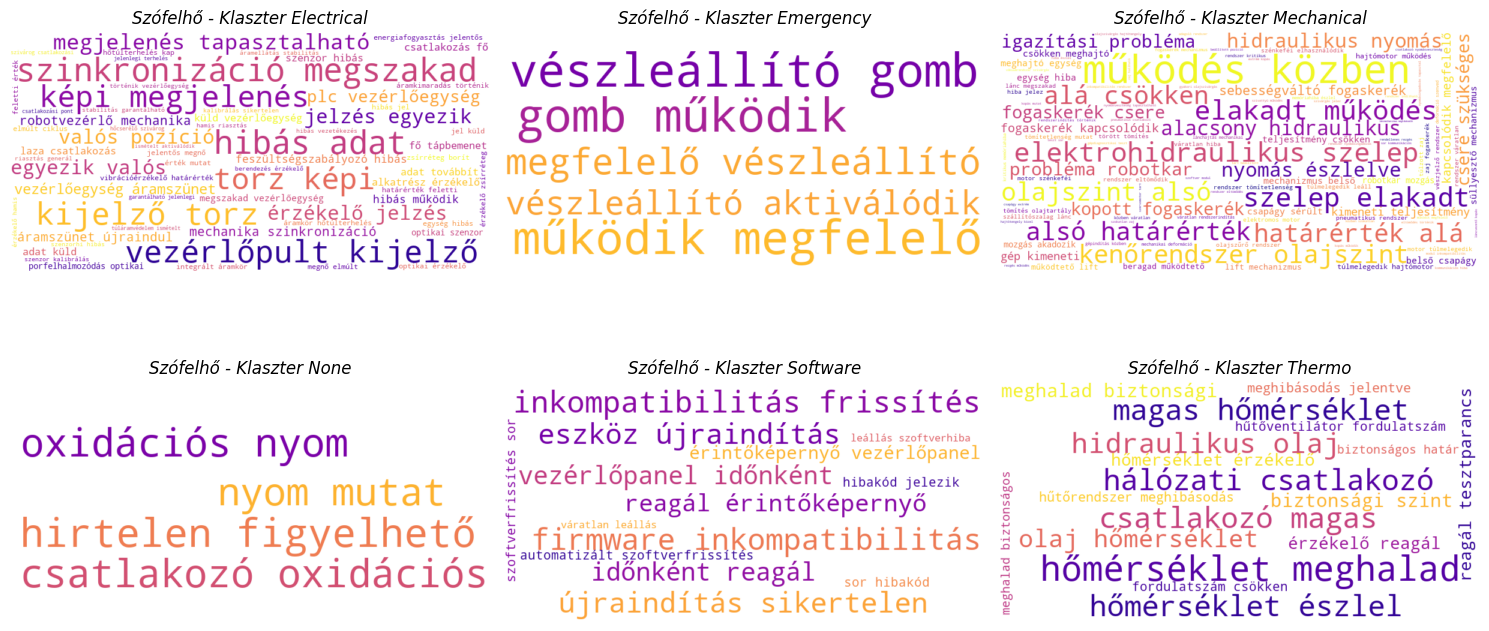

In [18]:
# Plot word clouds
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i, (cluster, wc) in enumerate(wordclouds.items()):
    axs[i // 3, i % 3].imshow(wc, interpolation='bilinear')
    axs[i // 3, i % 3].axis("off")
    axs[i // 3, i % 3].set_title(f"Szófelhő - Klaszter {cluster}", fontstyle='italic')

for i in range(len(wordclouds), 6):
    axs[i // 3, i % 3].set_visible(False)

plt.tight_layout()
plt.show()

In [19]:
import plotly.express as px

# Preprocess data for Plotly chart
# monthly_counts_reset = monthly_counts.reset_index()
# monthly_counts_reset["Month"] = monthly_counts_reset["Month"].astype(str)
# monthly_counts_melted = monthly_counts_reset.melt(id_vars="Month", var_name="Cluster", value_name="Count")

monthly_counts_reset = monthly_counts.reset_index()
monthly_counts_reset["Month"] = monthly_counts_reset["Month"].dt.to_timestamp()  # Period → Timestamp
monthly_counts_melted = monthly_counts_reset.melt(id_vars="Month", var_name="Cluster", value_name="Count")


# Plotly stacked bar chart
fig = px.bar(
    monthly_counts_melted,
    x="Month",
    y="Count",
    color="Cluster",
    title="Hibajegyek klaszterei havi bontásban",
    labels={"Month": "Hónap", "Count": "Jegyek száma", "Cluster": "Klaszter"},
    color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_layout(
    barmode="stack",
    xaxis_title="Hónap",
    yaxis_title="Jegyek száma",
    template="plotly_white",
    height=600,
    width=1500,
    legend_title="Klaszterek")

fig.show()

In [20]:
fig = px.line(
    monthly_counts_reset,
    x="Month",
    y=monthly_counts_reset.columns[1:],
    title="Időbeli trendek a hibajegyek számában",
    labels={"value": "Jegyek száma", "Month": "Hónap"},
    color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_traces(line=dict(width=3))
fig.update_layout(
    template="plotly_dark",
    xaxis_title="Hónap",
    yaxis_title="Jegyek száma",
    height=600,
    width=1200,
    legend_title="Klaszterek")
fig.show()

In [21]:
### New keywords suggester

In [22]:
from collections import Counter

# Select the descriptions where the cluster is 'None'
none_texts = df[df["Cluster"] == "None"]["Cleaned_Description"]

# Extract nouns from the descriptions using HuSpacy
def extract_nouns(text):
    doc = nlp(text)
    # return [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    return [token.lemma_ for token in doc]

# Extract nouns from the 'None' cluster texts
nouns = []
for text in none_texts:
    nouns.extend(extract_nouns(text))

# Count the frequency of nouns
noun_counts = Counter(nouns)
most_common_nouns = noun_counts.most_common(20)

# 4 Suggest new keywords for extension
print("Suggested new keywords for extending the clusters_dict:")
suggested_clusters = {"Keywords": [word for word, count in most_common_nouns]}
print(suggested_clusters)

Suggested new keywords for extending the clusters_dict:
{'Keywords': ['hirtelen', 'figyelhető', 'csatlakozó', 'oxidációs', 'nyom', 'mutat']}


In [23]:
### Rows with'None' Clusters

In [24]:
# Count occurrences of each cluster
cluster_counts = df["Cluster"].value_counts()

# Get the count of rows where Cluster is 'None'
none_cluster_count = cluster_counts.get("None", 0)  

In [25]:
print(f"Number of rows in 'None' cluster: {none_cluster_count}")

Number of rows in 'None' cluster: 24


In [26]:
pd.set_option("display.max_rows", None)  
pd.set_option("display.max_columns", None) 
pd.set_option("display.max_colwidth", None)

# Display the 'None' cluster rows
none_cluster_rows = df[df["Cluster"] == "None"]

In [27]:
none_cluster_rows[["Date", "Description", "Cleaned_Description"]]

,Date,Description,Cleaned_Description
3,2023-01-02,Hirtelen áramfelvétel-növekedés figyelhető meg.,hirtelen figyelhető
6,2023-01-03,A csatlakozók oxidációs nyomokat mutatnak.,csatlakozó oxidációs nyom mutat
90,2023-01-31,Hirtelen áramfelvétel-növekedés figyelhető meg.,hirtelen figyelhető
242,2023-03-22,Hirtelen áramfelvétel-növekedés figyelhető meg.,hirtelen figyelhető
243,2023-03-23,A csatlakozók oxidációs nyomokat mutatnak.,csatlakozó oxidációs nyom mutat
287,2023-04-06,Hirtelen áramfelvétel-növekedés figyelhető meg.,hirtelen figyelhető
319,2023-04-17,A csatlakozók oxidációs nyomokat mutatnak.,csatlakozó oxidációs nyom mutat
355,2023-04-29,A csatlakozók oxidációs nyomokat mutatnak.,csatlakozó oxidációs nyom mutat
362,2023-05-01,A csatlakozók oxidációs nyomokat mutatnak.,csatlakozó oxidációs nyom mutat
434,2023-05-25,Hirtelen áramfelvétel-növekedés figyelhető meg.,hirtelen figyelhető
